In [35]:
import os
import random
from glob import glob
import cv2
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import (Conv2D, Conv2DTranspose, Dropout, Input, MaxPooling2D, concatenate,
                          BatchNormalization, Activation, multiply, Add , Input)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [36]:
DATASET_ROOT_DIR = '/kaggle/input/satellite-dataset/data'
IMAGE_DIMENSIONS = (128, 128)
NUM_BANDS = 12
TEST_SET_RATIO = 0.2
RANDOM_STATE_SEED = 42

In [37]:
def load_and_prepare_data(root_path):
    """Loads images and masks from the specified root directory."""
    image_folder = os.path.join(root_path, 'images')
    mask_folder = os.path.join(root_path, 'labels')

    image_paths = sorted(glob(os.path.join(image_folder, "*.tif")))
    mask_paths = sorted([p for p in glob(os.path.join(mask_folder, "*.png")) if "_" not in os.path.basename(p)])

    raw_images = [tiff.imread(path) for path in image_paths]
    raw_masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in mask_paths]

    return raw_images, raw_masks


In [38]:
def apply_global_normalization(image_data):
    if not image_data:
        return np.array([])

    all_bands_data = np.concatenate([img.reshape(-1, NUM_BANDS) for img in image_data], axis=0)

    min_vals = np.min(all_bands_data, axis=0)
    max_vals = np.max(all_bands_data, axis=0)

    normalized_image_list = []
    for img in image_data:
        normalized_img = (img - min_vals) / (max_vals - min_vals + 1e-7)
        normalized_image_list.append(normalized_img)

    return np.array(normalized_image_list)


In [39]:
def build_encoder_block(input_layer, num_filters, dropout_level=0.1):
    """Constructs a single block for the encoder path of the U-Net."""
    conv = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_layer)
    conv = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(conv)
    pool = MaxPooling2D((2, 2))(conv)
    pool = Dropout(dropout_level)(pool)
    return conv, pool

def build_decoder_block(input_layer, skip_features, num_filters, dropout_level=0.1):
    """Constructs a single block for the decoder path of the U-Net."""
    upsample = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_layer)
    merged = concatenate([upsample, skip_features], axis=3)
    merged = Dropout(dropout_level)(merged)
    conv = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(merged)
    conv = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(conv)
    return conv

def build_segmentation_network(input_dims=(*IMAGE_DIMENSIONS, NUM_BANDS)):
    """Builds the complete U-Net architecture."""
    inputs = Input(input_dims)
    s1, p1 = build_encoder_block(inputs, 64)
    s2, p2 = build_encoder_block(p1, 128)
    s3, p3 = build_encoder_block(p2, 256)
    s4, p4 = build_encoder_block(p3, 512)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    bridge = Conv2D(1024, (3, 3), activation='relu', padding='same')(bridge)
    d1 = build_decoder_block(bridge, s4, 512)
    d2 = build_decoder_block(d1, s3, 256)
    d3 = build_decoder_block(d2, s2, 128)
    d4 = build_decoder_block(d3, s1, 64)
    output_mask = Conv2D(1, (1, 1), activation='sigmoid')(d4)
    segmentation_model = Model(inputs=[inputs], outputs=[output_mask])
    return segmentation_model


In [40]:
def display_results(original_images, ground_truth, predictions, sample_count=5):
    if len(original_images) < sample_count:
        print(f"Warning: Not enough images to display. Displaying {len(original_images)} samples.")
        sample_count = len(original_images)
    if sample_count == 0:
        return

    plt.figure(figsize=(12, sample_count * 4))
    indices = random.sample(range(len(original_images)), sample_count)

    for i, idx in enumerate(indices):
        rgb_display = original_images[idx][..., [3, 2, 1]]
        plt.subplot(sample_count, 3, i * 3 + 1); plt.title("Input Image"); plt.imshow(rgb_display); plt.axis('off')
        plt.subplot(sample_count, 3, i * 3 + 2); plt.title("Ground Truth"); plt.imshow(ground_truth[idx], cmap='gray'); plt.axis('off')
        plt.subplot(sample_count, 3, i * 3 + 3); plt.title("Model Prediction"); plt.imshow(predictions[idx] > 0.5, cmap='gray'); plt.axis('off')
    plt.tight_layout(); plt.show()


In [41]:
satellite_images, ground_truth_masks = load_and_prepare_data(DATASET_ROOT_DIR)

In [42]:
normalized_images = apply_global_normalization(satellite_images)
processed_masks = np.expand_dims(np.array(ground_truth_masks), axis=-1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
        normalized_images, processed_masks, test_size=TEST_SET_RATIO, random_state=RANDOM_STATE_SEED)

In [44]:
unet_model = build_segmentation_network()
unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_12[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_142[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 64, 64,    │          0 │ conv2d_143[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 64, 64,    │          0 │ max_pooling2d_27… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 64, 64,    │     73,856 │ dropout_35[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_144[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 32, 32,    │          0 │ conv2d_145[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 32, 32,    │          0 │ max_pooling2d_28… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 32, 32,    │    295,168 │ dropout_36[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_146[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 16, 16,    │          0 │ conv2d_147[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 16, 16,    │          0 │ max_pooling2d_29… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ dropout_37[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_148[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 8, 8, 512) │          0 │ conv2d_149[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 8, 8, 512) │          0 │ max_pooling2d_30

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
training_callbacks = [EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)]
history = unet_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=8,
        epochs=100,
        callbacks=training_callbacks,
        verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7051 - loss: 0.6408

E0000 00:00:1753306770.112120     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753306770.346281     104 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.7059 - loss: 0.6389

E0000 00:00:1753306785.187156     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753306785.421270     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


31/31 ━━━━━━━━━━━━━━━━━━━━ 46s 741ms/step - accuracy: 0.7067 - loss: 0.6370 - val_accuracy: 0.7944 - val_loss: 0.4298
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8072 - loss: 0.4613 - val_accuracy: 0.8908 - val_loss: 0.3278
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8614 - loss: 0.3540 - val_accuracy: 0.9083 - val_loss: 0.2567
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8841 - loss: 0.3070 - val_accuracy: 0.9137 - val_loss: 0.2376
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9072 - loss: 0.2484 - val_accuracy: 0.9141 - val_loss: 0.2395
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9059 - loss: 0.2565 - val_accuracy: 0.9132 - val_loss: 0.2238
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9009 - loss: 0.2689 - val_accuracy: 0.9164 - val_loss: 0.2262
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9027 - loss: 0.2495 - val_accuracy: 0.9176 - val

In [46]:
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Set Accuracy: {test_accuracy*100:.2f}%")
predicted_masks = unet_model.predict(X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9740 - loss: 0.0762

E0000 00:00:1753307137.341256     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753307137.582423     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753307137.830126     106 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.9678 - loss: 0.0940
Test Set Accuracy: 96.46%


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(32, 128, 128, 12))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 873ms/step


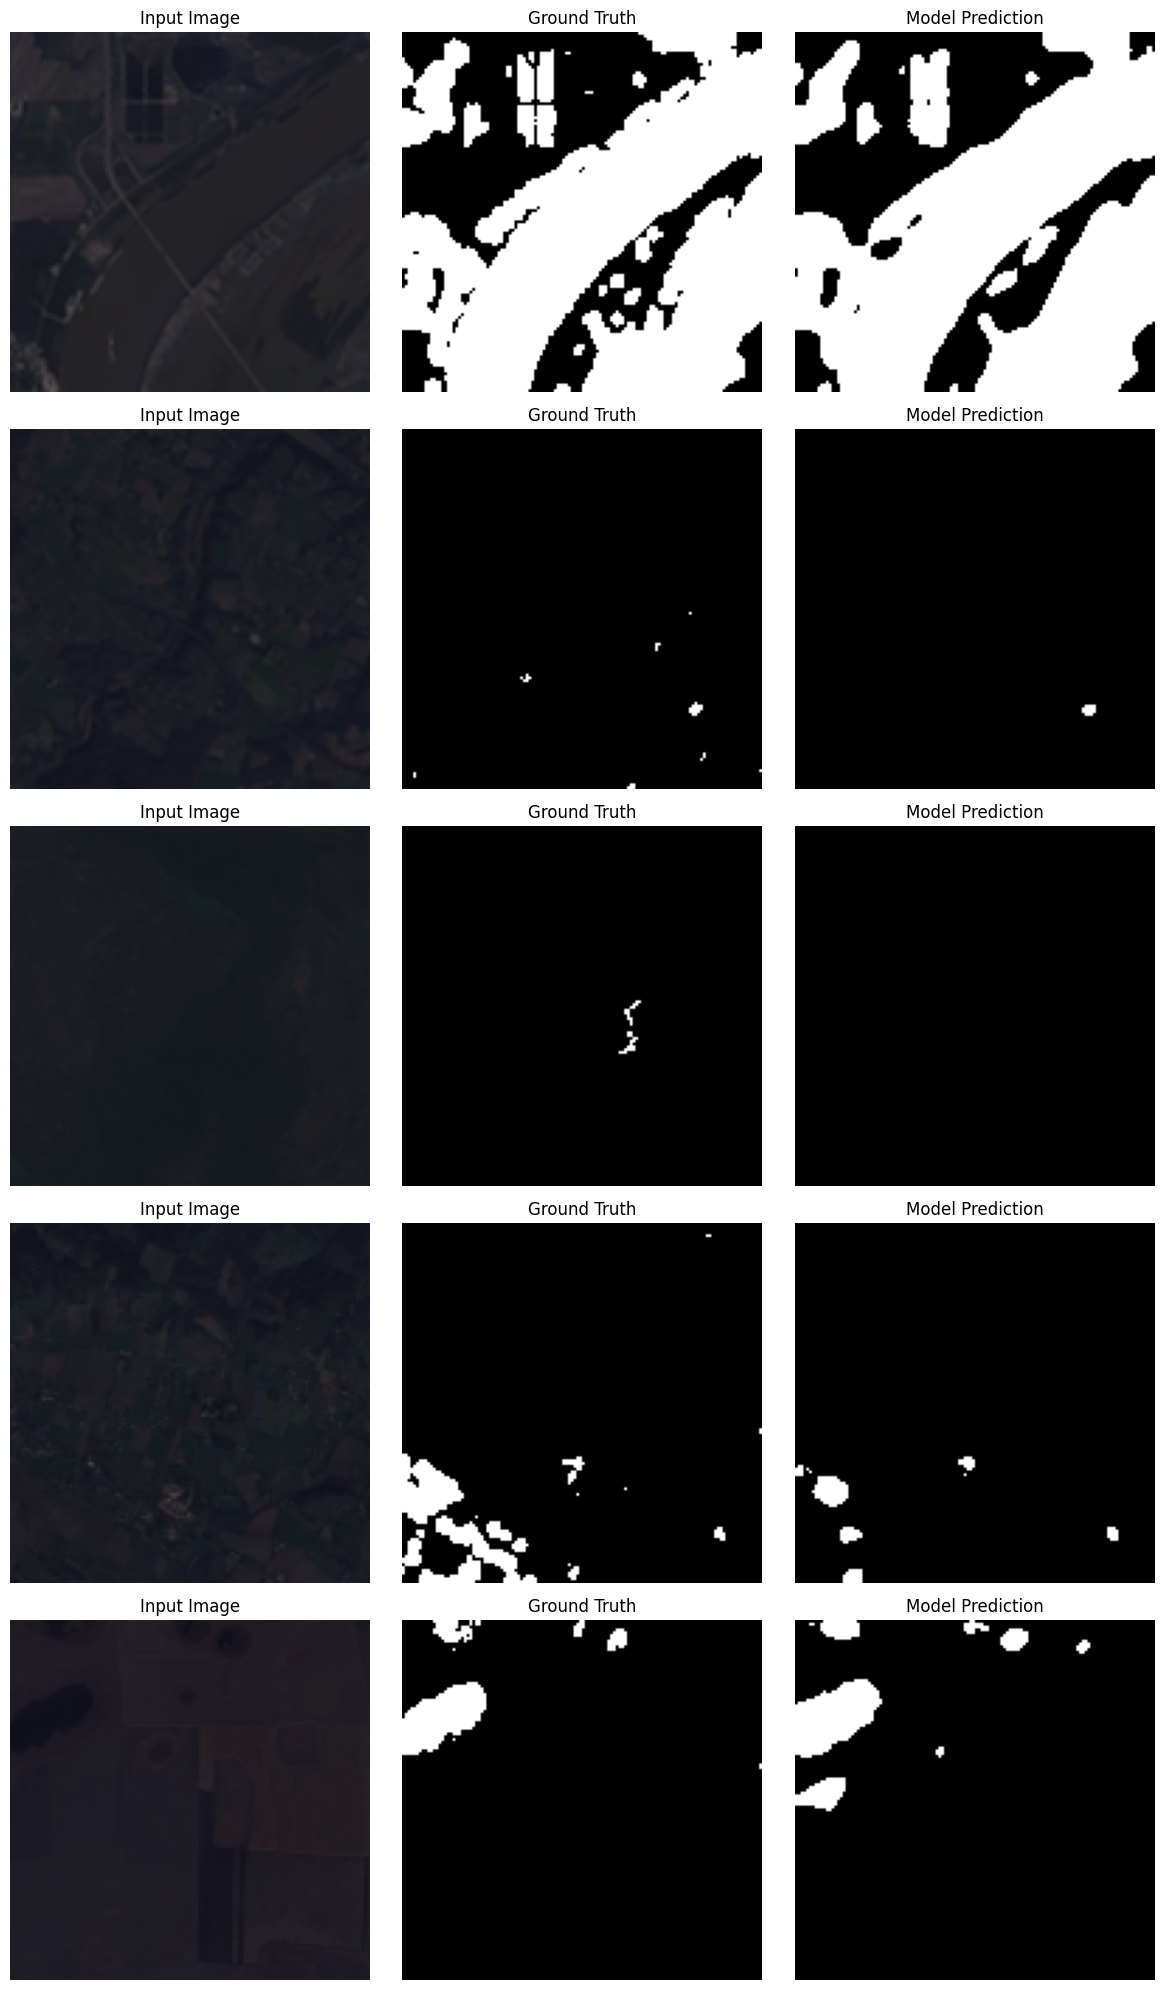

In [47]:
display_results(X_test, np.squeeze(y_test, axis=-1), np.squeeze(predicted_masks, axis=-1))

In [48]:
print("\n Evaluating Model on Test Set")

test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Set Loss: {test_loss:.4f}")
print(f"Test Set Accuracy: {test_accuracy*100:.2f}%")



 Evaluating Model on Test Set
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9678 - loss: 0.0940
Test Set Loss: 0.1029
Test Set Accuracy: 96.46%


In [49]:
print("\n Generating Predictions for Test Set ")
predicted_masks_test = unet_model.predict(X_test)
predicted_masks_binary = (predicted_masks_test > 0.5).astype(np.uint8)

def calculate_f1_score(true_masks, pred_masks):
        
    true_masks_flat = true_masks.flatten()
    pred_masks_flat = pred_masks.flatten()
    return f1_score(true_masks_flat, pred_masks_flat)

f1 = calculate_f1_score(y_test, predicted_masks_binary)
print(f"Test Set F1-Score: {f1:.4f}")



 Generating Predictions for Test Set 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Test Set F1-Score: 0.9201



 Displaying Visual Results from Test Set


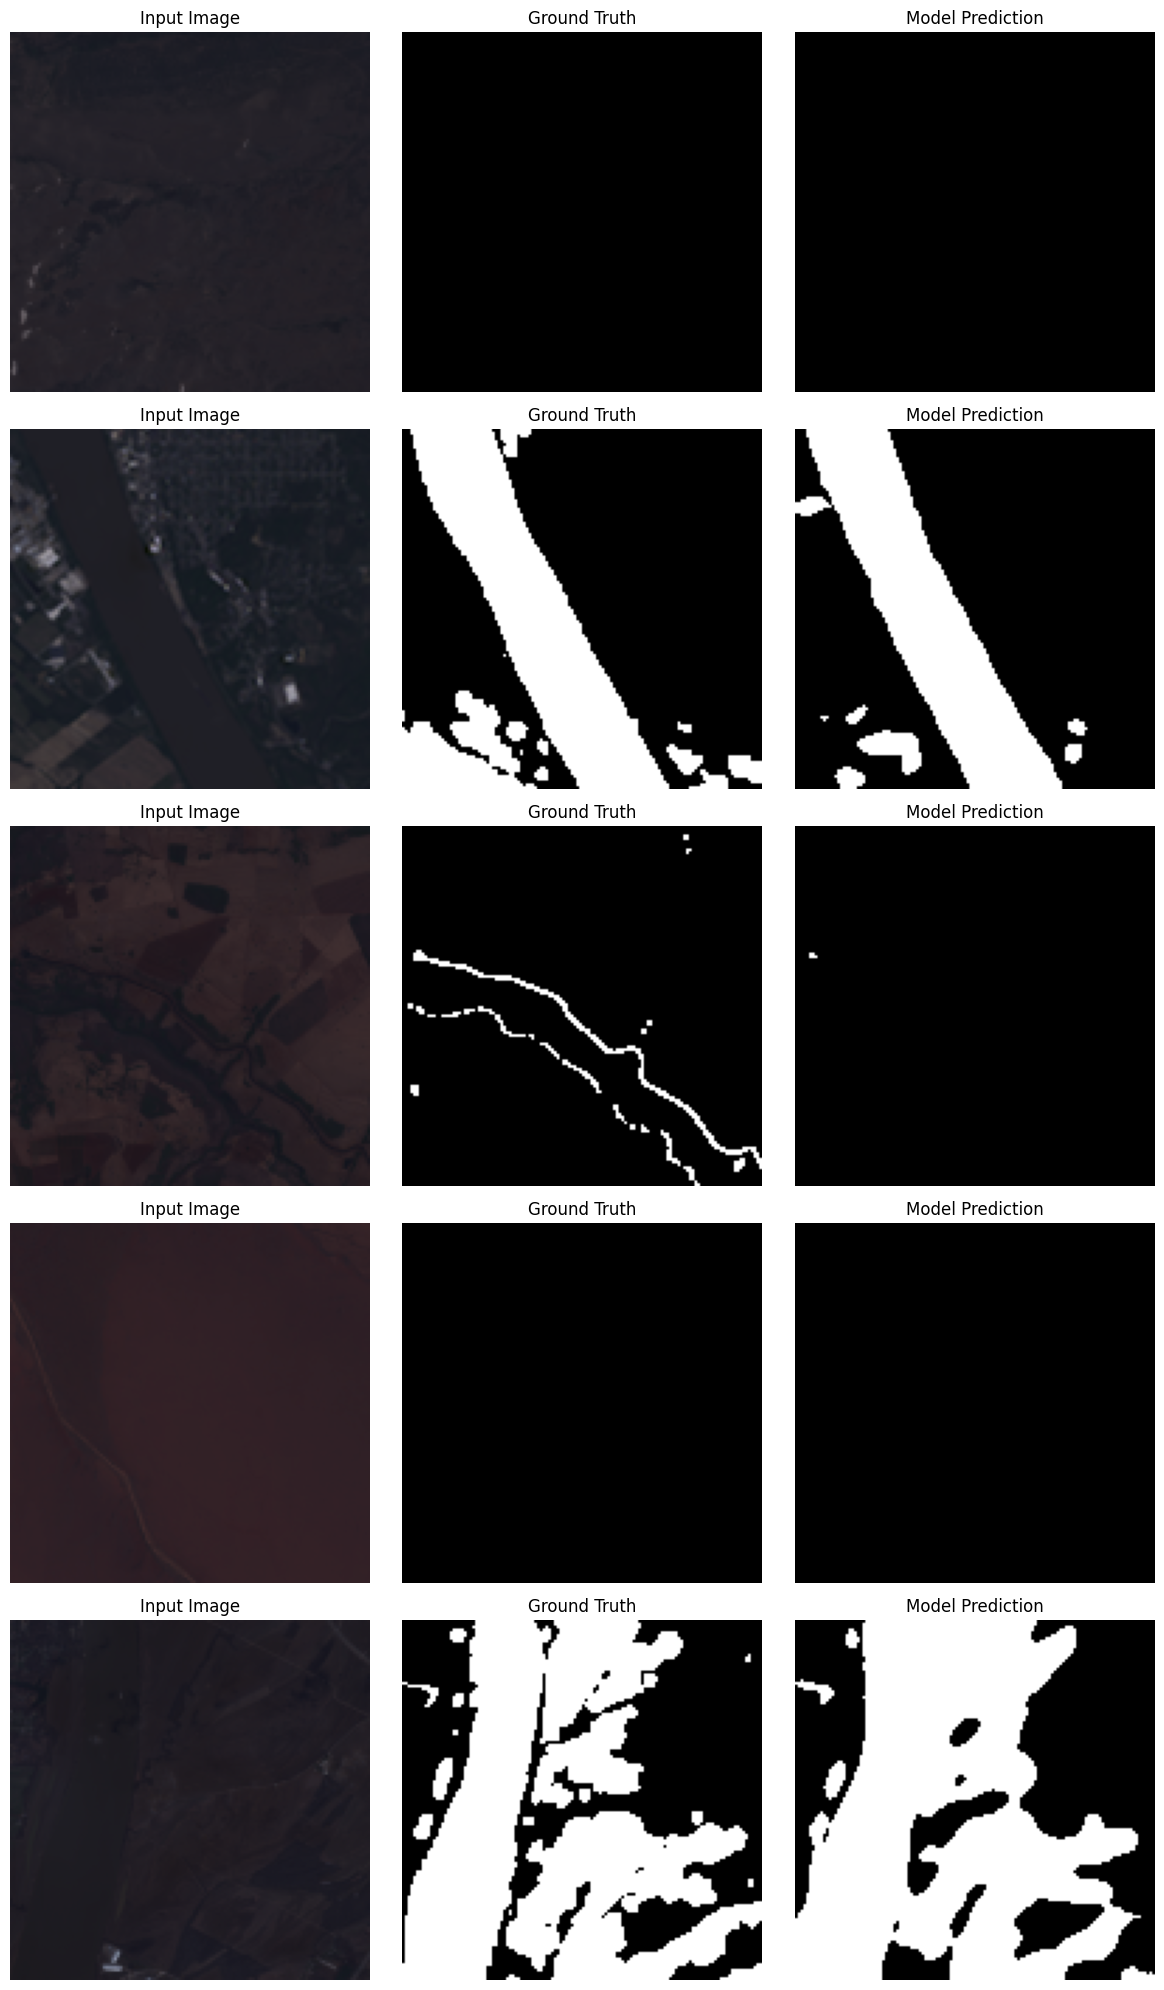

In [50]:
print("\n Displaying Visual Results from Test Set")
display_results(
    X_test,
    np.squeeze(y_test, axis=-1),
    np.squeeze(predicted_masks_binary, axis=-1)
)